## Import libs

In [1]:
import sklearn

## Plotting functions

In [2]:
# following function source: 
# https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

## Load data

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load preprocessed signal and create labels(pre ictal label is 1 && inter ictal label is 0)
pre_ictal = np.load('pre_ictal_pca.npy')
inter_ictal = np.load('inter_ictal_pca.npy')
pre_ictal_label = np.ones(np.size(pre_ictal, axis=0))
inter_ictal_label = np.zeros(np.size(inter_ictal, axis=0))

# concate pre_ictal and inter_ictal
trainset = np.concatenate((pre_ictal, inter_ictal), axis=0)
labelset = np.concatenate((pre_ictal_label, inter_ictal_label), 
                         axis=0)

# onehot encoding labels
labelset_onehot = np.zeros((np.size(labelset), int(np.max(labelset))+1))
labelset_onehot[np.arange(labelset.size), labelset.astype(int)]  = 1

# Split them into train and test set
X_train, X_test, y_train, y_test = train_test_split(trainset, labelset_onehot,
                                                   test_size=0.2,
                                                   random_state=66,
                                                   shuffle=True)

# Network 
Reference link: https://github.com/coreylammie/Memristive-Seizure-Detection-and-Prediction-by-Parallel-Convolutional-Neural-Networks/blob/master/network_training/Network.py

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import brevitas.nn as qnn
from torch.utils.data import DataLoader, TensorDataset


### Network Definition
class ParallelConvolution(nn.Module):
    def __init__(self, size=32):
        super(ParallelConvolution, self).__init__()
        self.conv1 = qnn.QuantConv1d(1,32,size,weight_bit_width=6)
        self.conv2 = qnn.QuantConv1d(1,32,62-size,weight_bit_width=6)
        self.avgpool = nn.AvgPool1d(2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.linear = qnn.QuantLinear(1088,8,bias=True,weight_bit_width=4)
        self.classification = qnn.QuantLinear(8,2,bias=True,weight_bit_width=4)
# comment: This code use QuantConv1d rather than nn.conv1d.quantization aware training allowing 
# you to train deep neural netowrks with low-bit precision activations and weights which allows to save computational resources.

    def forward(self,x):
        out1 = F.relu(self.conv1(x))
        out2 = F.relu(self.conv2(x))
        x = torch.cat((out1, out2),dim=2)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        out = self.classification(x)
        return out

In [6]:
# Running on GPU or CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device),'\n')

# Identify network size
network_size = 32
network = ParallelConvolution(size=network_size).to(device, dtype=torch.float)

# Identify dataset
dataset = TensorDataset(torch.Tensor(X_train[:,np.newaxis,:]),
                        torch.Tensor(y_train))
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

loss_function = nn.BCEWithLogitsLoss()  # LOSS FUNCTION????
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)





num_epochs = 100
for epoch in range(num_epochs):
    network.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        outputs = network(inputs)
        
            
        loss = loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        network.eval()
        
        running_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {running_loss / len(train_loader)}")

#         outputs = outputs.cpu().detach().numpy()
#         labels = labels.cpu().detach().numpy()
#         outputs = np.argmax(outputs,axis=1)
#         labels = np.argmax(labels,axis=1)
#         trainCM = np.add(trainCM, sklearn.metrics.confusion_matrix(outputs, labels, labels=[0, 1]))
#         trainCorrect += np.sum(outputs==labels)
#         trainTotal += len(outputs)
#         trainOutputs = np.append(trainOutputs,outputs.reshape((-1,1)),axis=0)
#         trainLabels = np.append(trainLabels,labels.reshape((-1,1)),axis=0)

Using cpu device 

Epoch [1/100] Loss: 15.464973449707031
Epoch [1/100] Loss: 28.83788299560547
Epoch [1/100] Loss: 40.34714380900065
Epoch [2/100] Loss: 17.64203135172526
Epoch [2/100] Loss: 25.74364471435547
Epoch [2/100] Loss: 28.910377820332844
Epoch [3/100] Loss: 11.703492482503256
Epoch [3/100] Loss: 20.096908569335938
Epoch [3/100] Loss: 24.013692537943523
Epoch [4/100] Loss: 8.084925333658854
Epoch [4/100] Loss: 16.693448384602863
Epoch [4/100] Loss: 23.9409122467041
Epoch [5/100] Loss: 16.946489969889324
Epoch [5/100] Loss: 21.14346726735433
Epoch [5/100] Loss: 21.439180612564087
Epoch [6/100] Loss: 12.325567881266275
Epoch [6/100] Loss: 15.845197041829428
Epoch [6/100] Loss: 19.689446767171223
Epoch [7/100] Loss: 11.198530832926432
Epoch [7/100] Loss: 13.785601933797201
Epoch [7/100] Loss: 18.0621436436971
Epoch [8/100] Loss: 5.697902679443359
Epoch [8/100] Loss: 7.344428380330403
Epoch [8/100] Loss: 10.109773953755697
Epoch [9/100] Loss: 7.734704335530599
Epoch [9/100] Loss:

Epoch [80/100] Loss: 2.426807085673014
Epoch [80/100] Loss: 2.8012446959813437
Epoch [81/100] Loss: 4.491562525431315
Epoch [81/100] Loss: 4.846944014231364
Epoch [81/100] Loss: 4.854084670543671
Epoch [82/100] Loss: 2.757102648417155
Epoch [82/100] Loss: 2.9170520504315696
Epoch [82/100] Loss: 3.4710054198900857
Epoch [83/100] Loss: 2.0999151865641275
Epoch [83/100] Loss: 2.1419704953829446
Epoch [83/100] Loss: 2.4622716506322226
Epoch [84/100] Loss: 1.4504350026448567
Epoch [84/100] Loss: 1.4504486169898883
Epoch [84/100] Loss: 1.4505050100560766
Epoch [85/100] Loss: 2.525259017944336
Epoch [85/100] Loss: 2.54440555597345
Epoch [85/100] Loss: 3.0750614566107592
Epoch [86/100] Loss: 3.9114271799723306
Epoch [86/100] Loss: 3.9122031539833793
Epoch [86/100] Loss: 3.9126288356104246
Epoch [87/100] Loss: 3.3734423319498696
Epoch [87/100] Loss: 3.439707492788633
Epoch [87/100] Loss: 3.439707492788633
Epoch [88/100] Loss: 1.527652104695638
Epoch [88/100] Loss: 1.66768945256869
Epoch [88/100

## Confusion matrix 

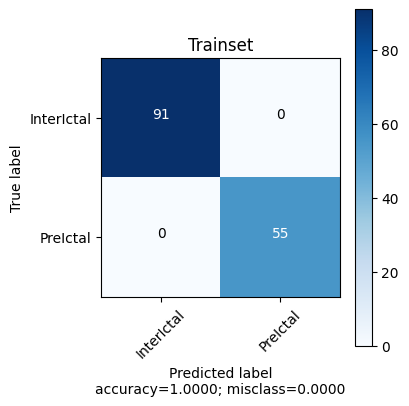

In [7]:
inputs = torch.Tensor(X_train[:,np.newaxis,:]).to(device, dtype=torch.float)
outputs = network(inputs)

outputs = outputs.cpu().detach().numpy()
outputs = np.argmax(outputs,axis=1)

plot_confusion_matrix(sklearn.metrics.confusion_matrix(outputs, np.argmax(y_train, axis=1)),
                     target_names=['InterIctal', 'PreIctal'],
                     cmap=None,
                     title='Trainset',
                     normalize=False)

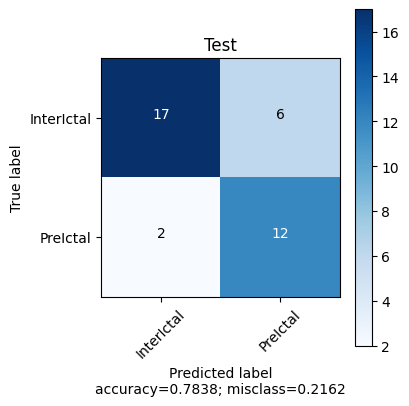

In [8]:
inputs = torch.Tensor(X_test[:,np.newaxis,:]).to(device, dtype=torch.float)
outputs = network(inputs)

outputs = outputs.cpu().detach().numpy()
outputs = np.argmax(outputs,axis=1)

plot_confusion_matrix(sklearn.metrics.confusion_matrix(outputs, np.argmax(y_test, axis=1)),
                     target_names=['InterIctal', 'PreIctal'],
                     cmap=None,
                     title='Test',
                     normalize=False)

## Accuracy

In [9]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(np.argmax(y_test, axis=1), outputs)

## Precision, recall and F1-score

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(np.argmax(y_test, axis=1), outputs)
recall = recall_score(np.argmax(y_test, axis=1), outputs)
f1 = f1_score(np.argmax(y_test, axis=1), outputs)



## Classification report

In [11]:
from sklearn.metrics import classification_report

report = classification_report(np.argmax(y_test, axis=1), outputs, 
                               target_names=['InterIctal', 'PreIctal'])


In [12]:
print(' Precision = ', precision,'\n',
      'Accuracy = ', accuracy, '\n',
     'Recall = ', recall, '\n',
     'F1 = ', f1, '\n\n\n',
     'Classification report: \n\n', report)

 Precision =  0.8571428571428571 
 Accuracy =  0.7837837837837838 
 Recall =  0.6666666666666666 
 F1 =  0.75 


 Classification report: 

               precision    recall  f1-score   support

  InterIctal       0.74      0.89      0.81        19
    PreIctal       0.86      0.67      0.75        18

    accuracy                           0.78        37
   macro avg       0.80      0.78      0.78        37
weighted avg       0.80      0.78      0.78        37



## Receiver operating characteristic(ROC) & Curve and area under the curve

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)  # y_pred_prob is the probability of the positive class
auc = roc_auc_score(y_true, y_pred_prob)

NameError: name 'y_true' is not defined